In [1]:
# Introduction to Multi_arm_bandits
import numpy as np
import multi_arm_bandits.multi_bandit_env.multi_arm_bandit as mab
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# Now you have bandits as well as multi-arm bandits.
# Lets see some of the bandits
bandit_1 = mab.bandit().normal(0,1)

# when triggered, bandit_1 outputs a reward sample from a gaussian distribution with mean 0 and std 1.
print(bandit_1.get_reward())

1.2001559593988986


In [3]:
bandit_2 = mab.bandit().uniform(2,3)
# we can find our expected return from this bandit after say a 1000 trials
bandit_2_returns = np.mean(np.array([bandit_2.get_reward() for i in range(1000)]))

print(bandit_2_returns)

2.49955635134


In [4]:
# Now a single bandit might not be so interesting, we will deal with multiple bandits or multi-arm-bandits
mab_1 = mab.multi_arm_bandit().gaussian(10, 5, 2, 1)
# constructs a multi_arm_bandit, with 10 arms, each having a N(r,1) reward distribution, 
# where 'r' is sampled from a Normal(5,2) distribution.

In [5]:
# To get reward now we must supply our arm-selection, lets say arm-4

reward = mab_1.get_reward(3)
print(reward)

7.251296595546271


In [6]:
# We can see the actual parameters of the arm-4, the mean and the std:
print(mab_1.bandit_list[3].params)
# we can see if our estimate of this mean value:
mab_1_4_returns = np.mean(np.array([mab_1.get_reward(3) for i in range(1000)]))
print(mab_1_4_returns)

[6.283716304788697, 1]
6.35599174496


In [8]:
# Now we form the 10-arm test-bed, which is a 10-armed bandit with each arm having a N(r,1) reward distribution, 
# where 'r' is sampled from a Normal(0,1) distribution.
test_bed = mab.multi_arm_bandit().gaussian(10, 0, 1, 1)

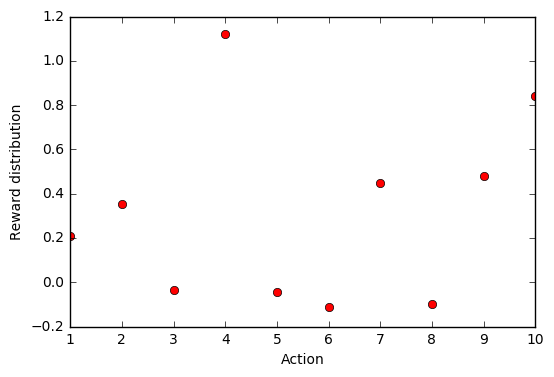

In [9]:
# Visualizing the rewards distribution
reward_means = [x.params[0] for x in test_bed.bandit_list]
plt.figure()
plt.plot(np.arange(1,11), reward_means,'ro')
plt.xlabel("Action")
plt.ylabel("Reward distribution")

In [10]:
# Each observation is made from 1000 steps on the test bed
# Each test is repeated 2000 times to get an estimate of the performance

# lets use a naive approach, we try each method once, and select the one with highest outcome as action for the next 990 steps.
val_estimate = np.zeros((10))
for i in range(10):
    val_estimate[i] = test_bed.get_reward(i)

# This is going to be my action selection for the next 990 runs
print('Selected action',np.argmax(val_estimate))

selected_action = np.argmax(val_estimate)
# we can keep tab of our performance:
avg_reward_list = [np.sum(val_estimate[0:i])/float(i) for i in range(1,11)]
avg_reward = avg_reward_list[9]
for i in range(10,1000):
    cur_reward = test_bed.get_reward(selected_action)
    avg_reward +=(cur_reward-avg_reward)/float(i)
    avg_reward_list.append(avg_reward)

print('Average Reward',avg_reward)


Selected action 5
Average Reward -0.0769834813608



### <center>Simple Bandit Algorithm with $\epsilon$-greedy method</center>


Initialize, for a =1 to k:<br>
$\quad$ Q(a) = 0<br>
$\quad$ N(a) = 0<br>
Repeat Forever:<br>
$\quad$ A = $argmax_a Q(a) \quad $ with probabiility $ 1-\epsilon $<br>
$\quad$ $\quad$ or<br>
$\quad$ A = any random Action $\quad$ with probability $\epsilon$<br>
$\quad$ R = reward(A)<br>
$\quad$ N(A) = N(A) +1<br>
$\quad$ Q(A) = Q(A) + $\frac{1}{n}\big[ R_n - Q_n\big]$<br>


In [11]:
# Write the code implementation of the above pseudo-code for 2000 itertions
# and print the total accumulated reward
epsilon = 0.1
actions = 10
Q = np.zeros(actions)
N = np.zeros(actions)
total_reward = 0
for i in range(1000):
    p = np.random.uniform(0,1)
    if p>epsilon:
        cur_action = np.argmax(Q)
    else:
        cur_action = np.random.choice(np.arange(actions),None)
    cur_reward = test_bed.get_reward(cur_action)
    N[cur_action] +=1
    Q[cur_action] += (cur_reward-Q[cur_action])/N[cur_action]
    total_reward +=cur_reward
print(total_reward)


820.0169682831321


In [12]:
# The action selector is a function, which takes as input 
# a array Q and an array N to output the action A at that time step.

# Given below is an example of a function which will return our epsilon greedy function, given epsilon.

def create_epsilon_greedy_selector(epsilon):
    
    def action_selector(Q,N):
        p = np.random.uniform(0,1)
        if p>epsilon:
            cur_action = np.argmax(Q)
        else:
            cur_action = np.random.choice(np.arange(len(Q)),None)
        return cur_action
    
    return action_selector

# For example
epsilon_selector = create_epsilon_greedy_selector(0.1)


In [13]:
# Now we can convert this run into a simulation/function
# Takes as input, the test_bed, max_iteration,and the action_selector
# and returns a list with the reward for each iteration,
# and a list containing 1 if the optimal action was taken, 0 otherwise

def bandit_simulation(mab,max_iter,action_selector):
    rewards = np.zeros((max_iter))
    obs_optimal = np.zeros((max_iter))
    optimal_action = np.argmax(np.array([x.params[0] for x in mab.bandit_list]))
    Q = np.zeros(len(mab.bandit_list))
    N = np.zeros(len(mab.bandit_list))
    
    for i in range(max_iter):
        cur_action = action_selector(Q,N)
        cur_reward = test_bed.get_reward(cur_action)
        N[cur_action] +=1
        Q[cur_action] += (cur_reward-Q[cur_action])/N[cur_action]
        rewards[i] = cur_reward#-avg_rewards[i-1])/float(i+1)
        if cur_action == optimal_action:
            obs_optimal[i] =1
        else:
            obs_optimal[i] =0
    return rewards, obs_optimal
        
    

In [14]:
# Now we want to find the average performance for different values of epsilon
# Run the Above algorithm for 2,000 times, 
# In each time keep a tab on the average acumalated reward over the thousand steps.

## Make varients of epsilon-greedy action selector from here
epsilon_selector = create_epsilon_greedy_selector(0.1)

max_iter = 1000
global_avg_rewards = np.zeros((max_iter))
global_obs_optimal = np.zeros((max_iter))
for i in range(2000):
    # Create a new test_bed
    test_bed = mab.multi_arm_bandit().gaussian(10, 0, 1, 1)
    cur_rewards, cur_obs_optimal = bandit_simulation(test_bed,max_iter,epsilon_selector)
    global_avg_rewards +=(cur_rewards-global_avg_rewards)/float(i+1)
    global_obs_optimal +=(cur_obs_optimal-global_obs_optimal)/float(i+1)

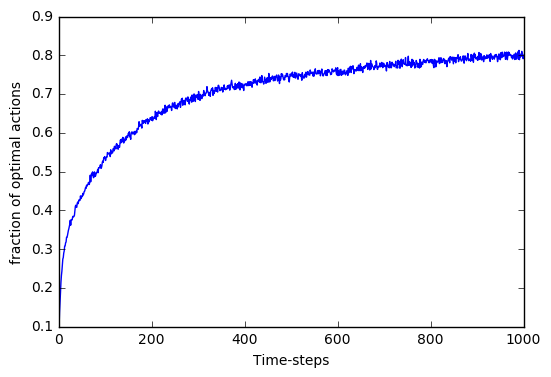

In [15]:
# Finally!
# Plot the performance!
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_obs_optimal)
plt.ylabel("fraction of optimal actions")
plt.xlabel("Time-steps")

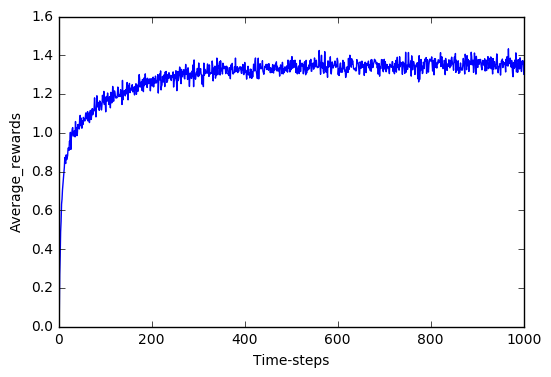

In [16]:

plt.figure()
plt.plot(np.arange(1,max_iter+1),global_avg_rewards)
plt.xlabel("Time-steps")
plt.ylabel("Average_rewards")

## Methods to encorage exploration

Now we will implement:
* Optimistic Initial Values
* Upper-Confidence Bound Action selection
* Gradient Bandit Method

In [17]:
# Optimistic initial value
# Just start off with an optimistic initial value
# Modify the bandit_simulation function to have optimistic inital values

def optimistic_bandit_simulation(mab,max_iter,action_selector,Q_val=None):
    rewards = np.zeros((max_iter))
    obs_optimal = np.zeros((max_iter))
    optimal_action = np.argmax(np.array([x.params[0] for x in mab.bandit_list]))
    if Q_val:
        Q = np.array([float(Q_val),]*len(mab.bandit_list))
    else: 
        best_reward = np.max(np.array([x.params[0] for x in mab.bandit_list]))
        best_reward +=1.5# Adding std for being really optimistic
        Q = np.array([best_reward,]*len(mab.bandit_list))
    N = np.zeros(len(mab.bandit_list))
    # print(best_reward,Q_val)
    for i in range(max_iter):
        cur_action = action_selector(Q,N)
        cur_reward = test_bed.get_reward(cur_action)
        N[cur_action] +=1
        Q[cur_action] += (cur_reward-Q[cur_action])/N[cur_action]
        rewards[i] = cur_reward#-avg_rewards[i-1])/float(i+1)
        if cur_action == optimal_action:
            obs_optimal[i] =1
        else:
            obs_optimal[i] =0
    return rewards, obs_optimal

In [18]:
# Lets see how it performs

epsilon_selector = create_epsilon_greedy_selector(0.1)

max_iter = 1000
global_avg_rewards_optimistic = np.zeros((max_iter))
global_obs_optimal_optimistic = np.zeros((max_iter))
for i in range(2000):
    # Create a new test_bed
    test_bed = mab.multi_arm_bandit().gaussian(10, 0, 1, 1)
    cur_rewards, cur_obs_optimal = optimistic_bandit_simulation(test_bed,max_iter,epsilon_selector,5)
    global_avg_rewards_optimistic +=(cur_rewards-global_avg_rewards_optimistic)/float(i+1)
    global_obs_optimal_optimistic +=(cur_obs_optimal-global_obs_optimal_optimistic)/float(i+1)

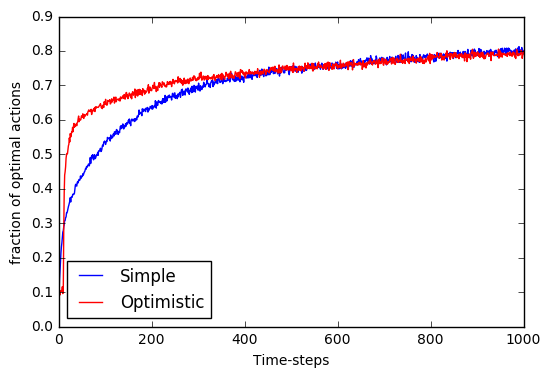

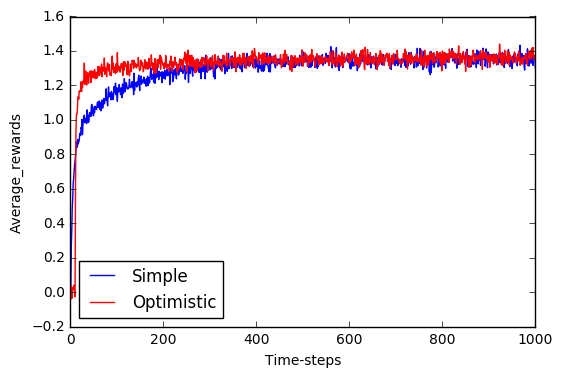

In [19]:
# Finally!
# Plot the performance!
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_obs_optimal,'blue',label="Simple")
plt.plot(np.arange(1,max_iter+1),global_obs_optimal_optimistic,'red',label='Optimistic')
plt.ylabel("fraction of optimal actions")
plt.xlabel("Time-steps")
plt.legend(loc='best')
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_avg_rewards,'blue',label="Simple")
plt.plot(np.arange(1,max_iter+1),global_avg_rewards_optimistic,'red',label="Optimistic")
plt.xlabel("Time-steps")
plt.ylabel("Average_rewards")
plt.ylabel("Average_rewards")
plt.legend(loc='best')


### Upper-Confidence-Bound Action Selection

$$ A_t= argmax_a \bigg[ Q_t (a) + c \sqrt{\frac{log(t)}{N_t (a)}} \bigg]  $$

In [20]:
# UCB
# write the code for the UCB-function, 
# Its an action selector function like before

def create_UCB_selector(c):
    
    def action_selector(Q,N):
        cur_estimate = Q+c*np.sqrt(np.log(np.sum(N)+1)/np.maximum(N,1))
        cur_action = np.argmax(cur_estimate)
        return cur_action
    
    return action_selector



In [21]:

## Make varients of epsilon-greedy action selector from here
UCB_selector = create_UCB_selector(2)

max_iter = 1000
global_avg_rewards_UCB = np.zeros((max_iter))
global_obs_optimal_UCB = np.zeros((max_iter))
for i in range(2000):
    # Create a new test_bed
    test_bed = mab.multi_arm_bandit().gaussian(10, 0, 1, 1)
    cur_rewards, cur_obs_optimal = bandit_simulation(test_bed,max_iter,UCB_selector)
    global_avg_rewards_UCB +=(cur_rewards-global_avg_rewards_UCB)/float(i+1)
    global_obs_optimal_UCB +=(cur_obs_optimal-global_obs_optimal_UCB)/float(i+1)

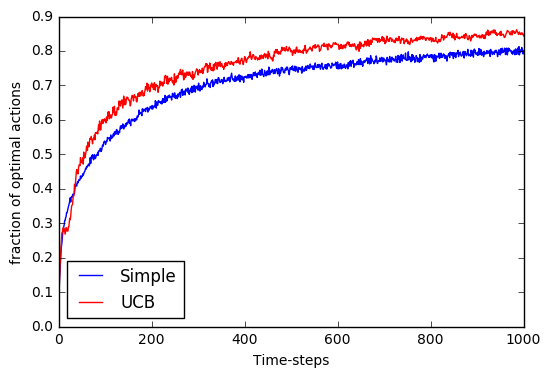

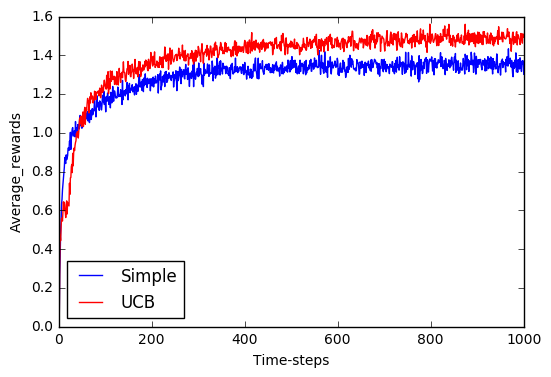

In [22]:
# Gradient Bandit
# Plot the performance!
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_obs_optimal,'blue',label="Simple")
plt.plot(np.arange(1,max_iter+1),global_obs_optimal_UCB,'red',label='UCB')
plt.ylabel("fraction of optimal actions")
plt.xlabel("Time-steps")
plt.legend(loc='best')
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_avg_rewards,'blue',label="Simple")
plt.plot(np.arange(1,max_iter+1),global_avg_rewards_UCB,'red',label="UCB")
plt.xlabel("Time-steps")
plt.ylabel("Average_rewards")
plt.ylabel("Average_rewards")
plt.legend(loc='best')

## Gradient Bandit

** Update Rules **

$$ H_{t+1}(A_t) = H_t (A_t) + \alpha(R_t − \overline{R_{t}})(1− \pi_t (A_t)) $$
and

$$ H_{t+1} (a) = H_t (a) + \alpha(R_t − \overline{R_{t}})\pi_t (a) \quad \forall a \neq A_t $$

$\overline{R_{t}}$ is the average of all the rewards up through and including time t. It is also called the **baseline reward**.

In [37]:
# Gradient Bandit
# We now have an update rule for H, rather than Q.
# Additionally the selection of action is done on the basis of its probability
# However, as the update rules are new,
# We make a new bandit similation function

def gradient_bandit_simulation(mab,max_iter,alpha,baseline=0):
    rewards = np.zeros((max_iter))
    obs_optimal = np.zeros((max_iter))
    optimal_action = np.argmax(np.array([x.params[0] for x in mab.bandit_list]))
    H = np.zeros(len(mab.bandit_list))
    N = np.zeros(len(mab.bandit_list))
    # print(best_reward,Q_val)
    for i in range(max_iter):
        prob = np.exp(H)/np.sum(np.exp(H))
        cur_action = np.random.choice(np.arange(len(mab.bandit_list)), p=prob)
        cur_reward = test_bed.get_reward(cur_action)
        # N[cur_action] +=1
        rewards[i] = cur_reward#-avg_rewards[i-1])/float(i+1)
        if cur_action == optimal_action:
            obs_optimal[i] =1
            H[cur_action] += alpha*(cur_reward-baseline)*(1- prob[cur_action])
        else:
            H[cur_action] -= alpha*(cur_reward-baseline)*(prob[cur_action])
    return rewards, obs_optimal

In [38]:
max_iter = 1000
global_avg_rewards_GB = np.zeros((max_iter))
global_obs_optimal_GB = np.zeros((max_iter))
for i in range(2000):
    # Create a new test_bed
    test_bed = mab.multi_arm_bandit().gaussian(10, 0, 1, 1)
    cur_rewards, cur_obs_optimal = gradient_bandit_simulation(test_bed,max_iter,0.4)
    global_avg_rewards_GB +=(cur_rewards-global_avg_rewards_GB)/float(i+1)
    global_obs_optimal_GB +=(cur_obs_optimal-global_obs_optimal_GB)/float(i+1)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in less


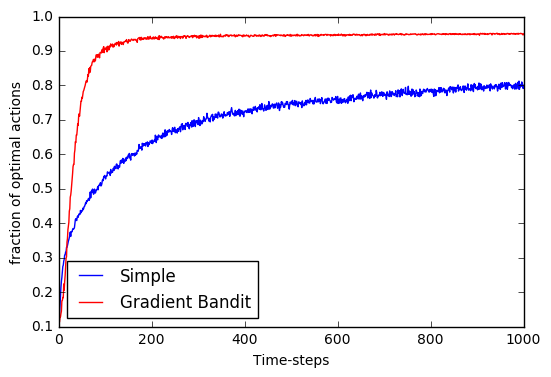

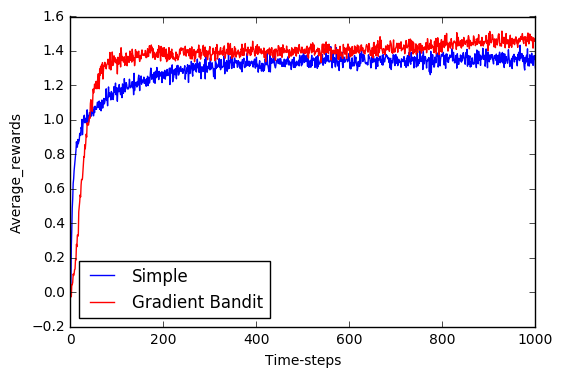

In [39]:
# Gradient Bandit
# Plot the performance!
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_obs_optimal,'blue',label="Simple")
plt.plot(np.arange(1,max_iter+1),global_obs_optimal_GB,'red',label='Gradient Bandit')
plt.ylabel("fraction of optimal actions")
plt.xlabel("Time-steps")
plt.legend(loc='best')
plt.figure()
plt.plot(np.arange(1,max_iter+1),global_avg_rewards,'blue',label="Simple")
plt.plot(np.arange(1,max_iter+1),global_avg_rewards_GB,'red',label="Gradient Bandit")
plt.xlabel("Time-steps")
plt.ylabel("Average_rewards")
plt.legend(loc='best')